In [1]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/Dataset

HumanActivityRecognition.ipynb	Untitled0.ipynb


In [19]:
import pandas as pd
import urllib
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import os
import time
from PIL import Image

from keras.applications.vgg16 import VGG16
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, Dropout
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam


import numpy as np
import pandas as pd

#Utility
import urllib
import os
import shutil
import time
from PIL import Image

#Vizualization
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
import cv2

#MODEL
import tensorflow as tf
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, Dropout, AveragePooling2D, Concatenate
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import MobileNetV2
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

df = pd.read_json("/content/drive/MyDrive/Dataset/Indian_Number_plates.json", lines=True)

In [20]:
df

,content,annotation,extras
0,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
1,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
2,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
3,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
4,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
...,...,...,...
232,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
233,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
234,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
235,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN


In [21]:
#Dictionray For Import
dataset = dict()
dataset["image_name"] = list()
dataset["image_width"] = list()
dataset["image_height"] = list()
dataset["top_x"] = list()
dataset["top_y"] = list()
dataset["bottom_x"] = list()
dataset["bottom_y"] = list()
#Extracting the Image and popualting the Dataset Dictionary
counter = 0
for index, row in df.iterrows():
    img = urllib.request.urlopen(row["content"])
    img = Image.open(img)
    img = img.convert('RGB')
    img.save(f"/content/drive/MyDrive/Dataset/indian_num-plate_dataset/licensed_car{counter}.jpeg","JPEG")

    dataset["image_name"].append(f"licensed_car{counter}.jpeg")
    
    data = row["annotation"]
    
    dataset["image_width"].append(data[0]["imageWidth"])
    dataset["image_height"].append(data[0]["imageHeight"])
    dataset["top_x"].append(data[0]["points"][0]["x"])
    dataset["top_y"].append(data[0]["points"][0]["y"])
    dataset["bottom_x"].append(data[0]["points"][1]["x"])
    dataset["bottom_y"].append(data[0]["points"][1]["y"])
    
    counter += 1
print(f"Downloaded {counter} car images.")

Downloaded 237 car images.


In [22]:
#Saved For Future Use
pd.DataFrame(dataset).to_csv("/content/drive/MyDrive/Dataset/indian_plates.csv", index=False)

In [23]:
df = pd.read_csv("/content/drive/MyDrive/Dataset/indian_plates.csv")
df.head()

,image_name,image_width,image_height,top_x,top_y,bottom_x,bottom_y
0,licensed_car0.jpeg,806,466,0.722084,0.587983,0.868486,0.688841
1,licensed_car1.jpeg,494,449,0.161943,0.850780,0.582996,1.000000
2,licensed_car2.jpeg,500,314,0.082000,0.697452,0.230000,0.828025
3,licensed_car3.jpeg,500,469,0.434000,0.667377,0.718000,0.765458
4,licensed_car4.jpeg,1001,563,0.208791,0.390764,0.865135,0.984014


In [24]:
WIDTH = 224
HEIGHT = 224

def display_car_image(index, scale=True, WIDTH=224, HEIGHT=224):
    images_dir = '/content/drive/MyDrive/Dataset/indian_num-plate_dataset/'
    
    img = cv2.imread(images_dir + df['image_name'].iloc[index])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, dsize=(WIDTH, HEIGHT))

    top_x = int(df['top_x'].iloc[index] * WIDTH)
    top_y = int(df['top_y'].iloc[index] * HEIGHT)
    bottom_x = int(df['bottom_x'].iloc[index] * WIDTH)
    bottom_y = int(df['bottom_y'].iloc[index] * HEIGHT)
    center_x = 20
    center_y = 20

    # adding bounding box to the number plate in the car
    bbox_width = 1
    bbox_color = (255, 0, 0)
    car = cv2.rectangle(img, (top_x, top_y), (bottom_x, bottom_y), bbox_color, bbox_width)
    car = cv2.circle(car, (center_x, center_x), radius=0, color=(0, 0, 255), thickness=-1)

    plt.figure(figsize=(20, 10))
    plt.imshow(car)
    plt.show()

    # cropping the number plate to display
    number_plate = Image.fromarray(img).crop((top_x + bbox_width, top_y + bbox_width, bottom_x, bottom_y))
    plt.figure(figsize=(5, 5))
    plt.imshow(number_plate)
    plt.show()


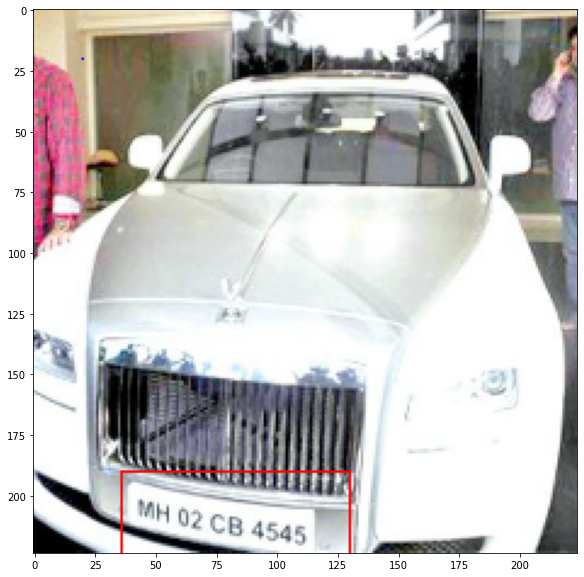

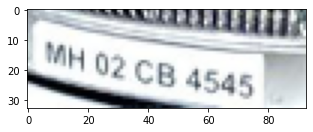

In [26]:
display_car_image(1)

In [27]:
#FUNCTION FOR PLOTTING
def plot_loss_acc(acc,val_acc,loss,val_loss):

    epochs=range(len(acc)) # Get number of epochs

    #------------------------------------------------
    # Plot training and validation accuracy per epoch
    #------------------------------------------------
    plt.plot(epochs, acc, 'r')
    plt.plot(epochs, val_acc, 'b')
    plt.title('Training and validation accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.grid()
    plt.figure()

    #------------------------------------------------
    # Plot training and validation loss per epoch
    #------------------------------------------------
    plt.plot(epochs, loss, 'r')
    plt.plot(epochs, val_loss, 'b')
    plt.title('Training and validation loss')
    plt.legend(['Train', 'Validation'], loc='lower left')
    plt.grid()

In [ ]:
#Creating Training and Validation Data Generators
datagen = ImageDataGenerator(rescale=1./255,
                             validation_split=0.1,
                            )

train_generator = datagen.flow_from_dataframe(
    df,
    directory="/content/drive/MyDrive/Dataset/indian_num-plate_dataset/",
    x_col="image_name",
    y_col=["top_x", "top_y", "bottom_x", "bottom_y"],
    target_size=(WIDTH, HEIGHT),
    batch_size=32, 
    class_mode="other",
    subset="training")

validation_generator = datagen.flow_from_dataframe(
    df,
    directory="/content/drive/MyDrive/Dataset/indian_num-plate_dataset/",
    x_col="image_name",
    y_col=["top_x", "top_y", "bottom_x", "bottom_y"],
    target_size=(WIDTH, HEIGHT),
    batch_size=32, 
    class_mode="other",
    subset="validation")

In [29]:
#Estimating Step size for train and validation set
STEP_SIZE_TRAIN = int(np.ceil(train_generator.n / train_generator.batch_size))
STEP_SIZE_VAL = int(np.ceil(validation_generator.n / validation_generator.batch_size))

print("Train step size:", STEP_SIZE_TRAIN)
print("Validation step size:", STEP_SIZE_VAL)

train_generator.reset()
validation_generator.reset()

Train step size: 7
Validation step size: 1


In [30]:
#Creating CNN
cnnmodel = Sequential()

cnnmodel.add(Conv2D(64, (3,3), activation='relu', input_shape=(WIDTH,HEIGHT,3)))
cnnmodel.add(MaxPooling2D(2,2))
cnnmodel.add(Conv2D(32, (3,3), activation='relu'))
cnnmodel.add(MaxPooling2D(2,2))
cnnmodel.add(Conv2D(16, (3,3), activation='relu'))
cnnmodel.add(MaxPooling2D(2,2))
cnnmodel.add(Flatten())
cnnmodel.add(Dense(128, activation="relu"))
cnnmodel.add(Dense(64, activation="relu"))
cnnmodel.add(Dense(64, activation="relu"))
cnnmodel.add(Dense(4, activation="sigmoid"))

cnnmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 10816)             0

In [32]:
cnnmodel.compile(optimizer=Adam(lr=0.0005), loss="mse", metrics=['acc'])
history = cnnmodel.fit_generator(train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=validation_generator,
    validation_steps=STEP_SIZE_VAL,
    epochs=30)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
7/7 [==============================] - 3s 339ms/step - loss: 0.0079 - acc: 0.9117 - val_loss: 0.0162 - val_acc: 0.6957
Epoch 2/30
7/7 [==============================] - 2s 265ms/step - loss: 0.0050 - acc: 0.8754 - val_loss: 0.0160 - val_acc: 0.6957
Epoch 3/30
7/7 [==============================] - 2s 262ms/step - loss: 0.0029 - acc: 0.9245 - val_loss: 0.0168 - val_acc: 0.7391
Epoch 4/30
7/7 [==============================] - 2s 262ms/step - loss: 0.0017 - acc: 0.9294 - val_loss: 0.0167 - val_acc: 0.6522
Epoch 5/30
7/7 [==============================] - 2s 282ms/step - loss: 0.0012 - acc: 0.9546 - val_loss: 0.0172 - val_acc: 0.6957
Epoch 6/30
7/7 [==============================] - 2s 285ms/step - loss: 8.4652e-04 - acc: 0.9569 - val_loss: 0.0173 - val_acc: 0.7826
Epoch 7/30
7/7 [==============================] - 2s 285ms/step - loss: 7.5925e-04 - acc: 0.9560 - val_loss: 0.0164 - val_acc: 0.7391
Epoch 8/30
7/7 [==============================] - 2s 286ms/step - loss: 4.7258e-04

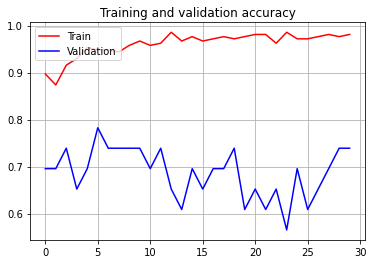

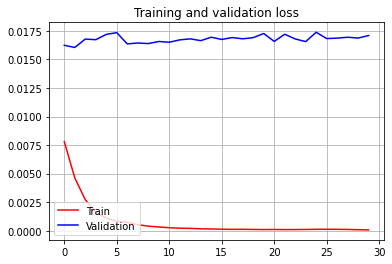

In [33]:
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

plot_loss_acc(acc,val_acc,loss,val_loss)

In [37]:
lucky_test_samples = np.random.randint(0, len(df), 5)
lucky_test_samples

array([104,  78, 129, 188,  31])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


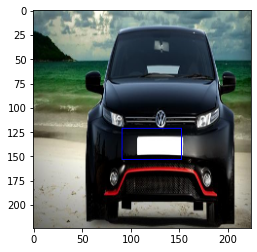

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


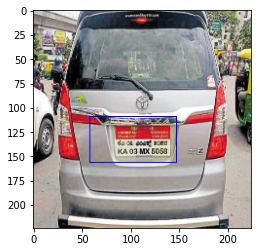

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


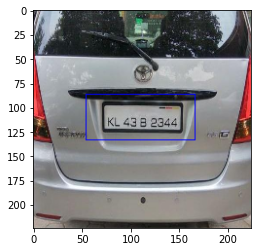

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


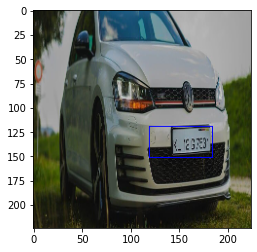

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


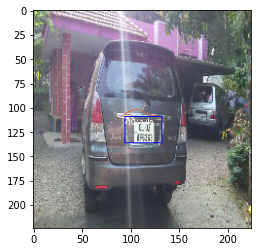

In [38]:

cnnmodel.evaluate_generator(validation_generator, steps=STEP_SIZE_VAL)
for idx, row in df.iloc[lucky_test_samples].iterrows():    
    img = cv2.resize(cv2.imread("/content/drive/MyDrive/Dataset/indian_num-plate_dataset/" + row[0]) / 255.0, dsize=(WIDTH, HEIGHT))
    y_hat = cnnmodel.predict(img.reshape(1, WIDTH, HEIGHT, 3)).reshape(-1) * WIDTH
    
    xt, yt = y_hat[0], y_hat[1]
    xb, yb = y_hat[2], y_hat[3]
    
    img = cv2.cvtColor(img.astype(np.float32), cv2.COLOR_BGR2RGB)
    image = cv2.rectangle(img, (xt, yt), (xb, yb), (0, 0, 255), 1)
    plt.imshow(image)
    plt.show()

In [ ]:
#VGG16 MODEL

In [39]:
VGG16model = Sequential()

VGG16model.add(VGG16(weights="imagenet", include_top=False, input_shape=(HEIGHT, WIDTH, 3)))
VGG16model.add(Flatten())
VGG16model.add(Dense(128, activation="relu"))
VGG16model.add(Dense(64, activation="relu"))
VGG16model.add(Dense(64, activation="relu"))
VGG16model.add(Dense(4, activation="sigmoid"))

VGG16model.layers[-6].trainable = False

VGG16model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               3211392   
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 260       
Total params: 17,938,756
Trainable params: 3,224,068
No

In [40]:
VGG16model.compile(optimizer=Adam(lr=0.0005), loss="mse", metrics=['acc'])
history = VGG16model.fit_generator(train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=validation_generator,
    validation_steps=STEP_SIZE_VAL,
    epochs=30)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
7/7 [==============================] - 5s 464ms/step - loss: 0.0578 - acc: 0.3654 - val_loss: 0.0562 - val_acc: 0.4783
Epoch 2/30
7/7 [==============================] - 2s 310ms/step - loss: 0.0355 - acc: 0.5171 - val_loss: 0.0245 - val_acc: 0.6087
Epoch 3/30
7/7 [==============================] - 2s 308ms/step - loss: 0.0152 - acc: 0.6809 - val_loss: 0.0178 - val_acc: 0.4348
Epoch 4/30
7/7 [==============================] - 2s 265ms/step - loss: 0.0076 - acc: 0.7541 - val_loss: 0.0140 - val_acc: 0.7391
Epoch 5/30
7/7 [==============================] - 2s 306ms/step - loss: 0.0055 - acc: 0.7774 - val_loss: 0.0153 - val_acc: 0.6522
Epoch 6/30
7/7 [==============================] - 2s 305ms/step - loss: 0.0033 - acc: 0.9228 - val_loss: 0.0149 - val_acc: 0.6087
Epoch 7/30
7/7 [==============================] - 2s 299ms/step - loss: 0.0023 - acc: 0.9381 - val_loss: 0.0159 - val_acc: 0.7826
Epoch 8/30
7/7 [==============================] - 2s 289ms/step - loss: 0.0017 - acc: 0.92

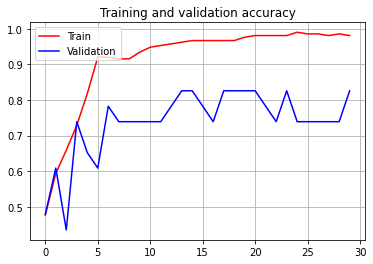

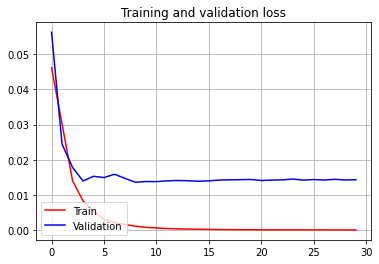

In [41]:
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

plot_loss_acc(acc,val_acc,loss,val_loss)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


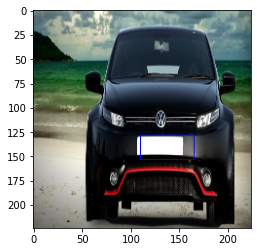

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


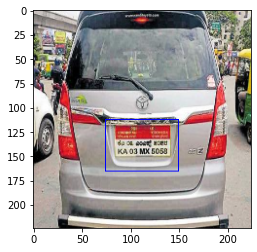

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


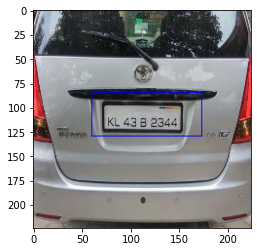

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


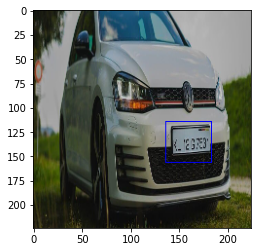

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


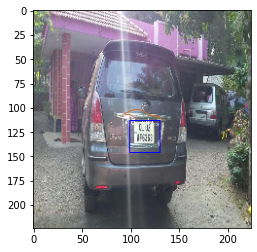

In [42]:

VGG16model.evaluate_generator(validation_generator, steps=STEP_SIZE_VAL)
for idx, row in df.iloc[lucky_test_samples].iterrows():    
    img = cv2.resize(cv2.imread("/content/drive/MyDrive/Dataset/indian_num-plate_dataset/" + row[0]) / 255.0, dsize=(WIDTH, HEIGHT))
    y_hat = VGG16model.predict(img.reshape(1, WIDTH, HEIGHT, 3)).reshape(-1) * WIDTH
    
    xt, yt = y_hat[0], y_hat[1]
    xb, yb = y_hat[2], y_hat[3]
    
    img = cv2.cvtColor(img.astype(np.float32), cv2.COLOR_BGR2RGB)
    image = cv2.rectangle(img, (xt, yt), (xb, yb), (0, 0, 255), 1)
    plt.imshow(image)
    plt.show()

In [ ]:
#MOBILENETV2

In [43]:
MNV2model = Sequential()

MNV2model.add(MobileNetV2(weights="imagenet", include_top=False, input_shape=(HEIGHT, WIDTH, 3)))
MNV2model.add(Flatten())
MNV2model.add(Dense(128, activation="relu"))
MNV2model.add(Dense(64, activation="relu"))
MNV2model.add(Dense(64, activation="relu"))
MNV2model.add(Dense(4, activation="sigmoid"))

MNV2model.layers[-6].trainable = False

MNV2model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_2 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               8028288   
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 260       
Total params: 10,298,948
Trainable params: 8,040,964
Non-

In [44]:
MNV2model.compile(optimizer=Adam(lr=0.0005), loss="mse", metrics=['acc'])
history3 = MNV2model.fit_generator(train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=validation_generator,
    validation_steps=STEP_SIZE_VAL,
    epochs=30)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
7/7 [==============================] - 6s 463ms/step - loss: 0.0994 - acc: 0.3768 - val_loss: 0.1125 - val_acc: 0.5217
Epoch 2/30
7/7 [==============================] - 2s 296ms/step - loss: 0.1019 - acc: 0.5000 - val_loss: 0.1234 - val_acc: 0.5217
Epoch 3/30
7/7 [==============================] - 2s 296ms/step - loss: 0.1039 - acc: 0.5529 - val_loss: 0.0987 - val_acc: 0.5217
Epoch 4/30
7/7 [==============================] - 2s 274ms/step - loss: 0.0984 - acc: 0.5636 - val_loss: 0.1006 - val_acc: 0.5217
Epoch 5/30
7/7 [==============================] - 2s 289ms/step - loss: 0.0953 - acc: 0.5450 - val_loss: 0.1456 - val_acc: 0.5217
Epoch 6/30
7/7 [==============================] - 2s 287ms/step - loss: 0.1088 - acc: 0.5131 - val_loss: 0.1306 - val_acc: 0.5217
Epoch 7/30
7/7 [==============================] - 2s 289ms/step - loss: 0.1000 - acc: 0.5615 - val_loss: 0.1103 - val_acc: 0.5217
Epoch 8/30
7/7 [==============================] - 2s 294ms/step - loss: 0.0859 - acc: 0.55

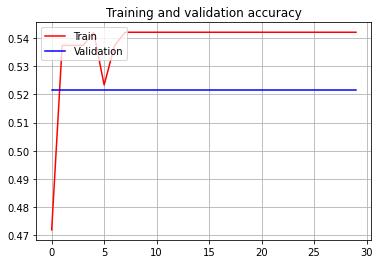

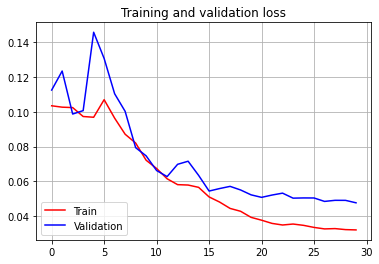

In [45]:
acc=history3.history['acc']
val_acc=history3.history['val_acc']
loss=history3.history['loss']
val_loss=history3.history['val_loss']

plot_loss_acc(acc,val_acc,loss,val_loss)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


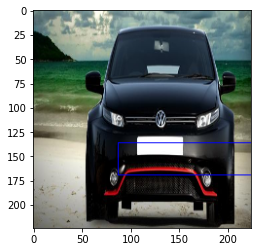

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


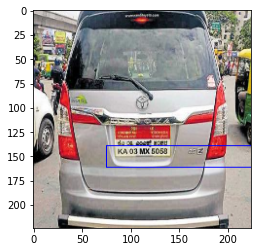

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


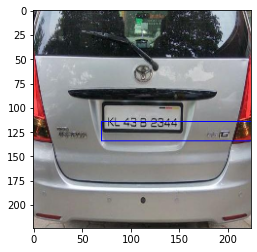

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


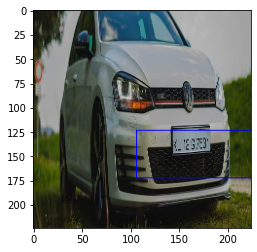

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


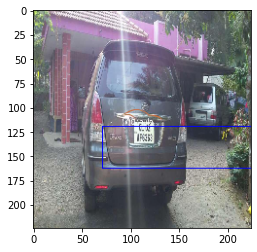

In [46]:

MNV2model.evaluate_generator(validation_generator, steps=STEP_SIZE_VAL)
for idx, row in df.iloc[lucky_test_samples].iterrows():    
    img = cv2.resize(cv2.imread("/content/drive/MyDrive/Dataset/indian_num-plate_dataset/" + row[0]) / 255.0, dsize=(WIDTH, HEIGHT))
    y_hat = MNV2model.predict(img.reshape(1, WIDTH, HEIGHT, 3)).reshape(-1) * WIDTH
    
    xt, yt = y_hat[0], y_hat[1]
    xb, yb = y_hat[2], y_hat[3]
    
    img = cv2.cvtColor(img.astype(np.float32), cv2.COLOR_BGR2RGB)
    image = cv2.rectangle(img, (xt, yt), (xb, yb), (0, 0, 255), 1)
    plt.imshow(image)
    plt.show()